# __ANALISIS PRELIMINAR: DATA WRANGLING__

## Introducción

Este notebook se enfoca en el proceso de Data Wrangling utilizando datos extraídos de las plataformas Yelp y Google Maps. El Data Wrangling implica una exploración inicial, limpieza y transformación de los datos con el objetivo de prepararlos para análisis posteriores. Este paso es crucial en cualquier proyecto de ciencia de datos para garantizar la calidad y utilidad de los datos.

## Configuraciones Globales e Importaciones

En esta sección, se instalan e importan todas las librerías y/o módulos necesarios para el proceso ETL (Extract, Transform, Load) y se establecen configuraciones globales de ser requerido. Se utilizan las siguientes librerías y herramientas:

In [1]:
import warnings
warnings.filterwarnings("ignore") # Se utiliza para gestionar las advertencias y mantener el código limpio.
     

In [2]:
import os # Proporciona funciones para interactuar con el sistema operativo.
import requests # Se utiliza para realizar solicitudes HTTP.
import pandas as pd # Una librería de análisis de datos.
import seaborn as sns #S e utiliza para la visualización de datos.
import pyspark.pandas as ps # Proporciona una interfaz para trabajar con datos en Spark utilizando el formato de DataFrame de pandas.
import json # Se utiliza para trabajar con datos en formato JSON.


from matplotlib import pyplot as plt # Una librería para la visualización de datos en Python.
from pyspark.sql import SparkSession # Se utiliza para crear una instancia de SparkSession, que es la entrada principal para trabajar con Spark SQL.
from pyspark.sql import functions as F #  Proporciona funciones para trabajar con datos en Spark DataFrame.
from pyspark.sql.functions import array_contains # Esta función se utiliza para filtrar los datos basados en la presencia de un valor en un array.
from pyspark.sql.functions import col # Se utiliza para acceder a una columna en un DataFrame de Spark.

In [3]:
# Crear una sesión de Spark
spark = SparkSession.builder\
        .master("local")\
        .appName("EDA-Preliminar")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# __GOOGLE MAPS__

### Dataset: metadata-sitios

__DECLARACIÓN DE LA RUTA DE LOS DATA SET__

In [6]:
# Ruta local donde se encuentran los archivos JSON
ruta_local = "C:/Users/Usuario/Desktop/Proyecto Final/metadata-sitios"

# Lista para almacenar los DataFrames de metadatos
metadata_df = []

# Iteración sobre los archivos JSON del 1 al 11
for i in range(1, 12):
    # Lectura del archivo JSON utilizando Spark
    archivo = spark.read.json(f"{ruta_local}/{i}.json")
    
    # Conversión de la columna "MISC" a tipo de datos "string"
    archivo = archivo.withColumn("MISC", col("MISC").cast("string"))
    
    # Agregar el DataFrame a la lista de metadatos
    metadata_df.append(archivo)

# DataFrame final para almacenar los datos combinados
df_final = metadata_df[0]

# Unión de los DataFrames de metadatos utilizando unionByName
for dataframe in metadata_df[1:]:
    df_final = df_final.unionByName(dataframe)

# Sobrescribir metadata_df con el DataFrame final combinado
metadata_df = df_final


In [7]:
# Mostrar el DataFrame
metadata_df.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [8]:
# Filtrado de Datos por Categoría "Fast Food"
fastfood = metadata_df.filter(F.col('name').like('%fast food%'))

# Mostrar el DataFrame resultante
fastfood.show()


+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|         longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Mao fast food, 84...|       4.3|[Colombian restau...|Hot dogs & burger...|0x88d9b89020a9342...|[[Wednesday, 5PM–...|         25.7328

En nuestro filtrado de comidas rapida solo nos muestra 3 resultados en todo nuestro dataset

In [9]:
# Filtrado de Datos por Categoría "New York"
ubi_ny = metadata_df.filter(F.col('address').like('%new york%'))

# Mostrar el DataFrame resultante
ubi_ny.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                NULL|CUNY new york, Co...|       4.5|            [School]|                NULL|0x89c2f66ee150245...|                NULL|40.8203291999

En este filtrado nos muestra todo lo que hay en new york en nuestro dataset

In [10]:
# Filtrado de Datos por Categoría "Restaurant" que esten dentro de "New York"
restaurantes_ny = metadata_df.filter(
    (array_contains(F.col('category'), 'Restaurant')) &  # Asegura que sea un restaurante
    (F.col('address').like('%New York%'))          # Asegura que el estado sea New York
)

# Mostrar el DataFrame resultante
restaurantes_ny.show()

+--------------------+---------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|              address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|         longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+---------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{null, null, [Goo...| Raffaello Kosher ...|       3.4|        [Restaurant]|This casual joint...|0x89c258ffaeaba94...|                NULL|        40.7

In [101]:
# Filtrar los datos para incluir solo el restaurante "Sgambati's New Yo"
resultado_sgambati = metadata_df.filter(F.col('name').like("%Sgambati's New Yo%"))

# Mostrar el DataFrame resultante
resultado_sgambati.show()


+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+----------+------------------+--------------------+--------------+-----+--------------------+------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|  latitude|         longitude|                name|num_of_reviews|price|    relative_results|             state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+----------+------------------+--------------------+--------------+-----+--------------------+------------------+--------------------+
|{[Wheelchair acce...|Sgambati's New Yo...|       3.4|[Pizza restaurant...|                NULL|0x8802e40e3b00b01...|[[Thursday, 9:30A...| 44.465098|-87.94651689999999|Sgambati's New Y

Se elegio como cliente **Sgambati's New York** y se busco las cantidades de negocios que tenia en este dataframe, dando como **resultados 3 locales, lo cual dos estan permanente cerrados** 

Procederemos a un analisis más profundo de nuestro dataFrame

In [11]:
# Estructura del esquema del DataFrame 
metadata_df.printSchema()

root
 |-- MISC: string (nullable = true)
 |-- address: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- hours: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- price: string (nullable = true)
 |-- relative_results: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- state: string (nullable = true)
 |-- url: string (nullable = true)



- __MISC:__ Cadena de caracteres que puede contener información adicional no estructurada.
- __address:__ Dirección del lugar.
- __avg_rating:__ Calificación promedio del lugar, representada como un número decimal.
- __category:__ Array de cadenas que indica la categoría o categorías a las que pertenece el lugar.
- __description:__ Descripción del lugar.
- __gmap_id:__ Identificador único asociado al lugar en Google Maps.
- __hours:__ Array de arrays de cadenas que representan los horarios de apertura y cierre del lugar para diferentes días de la semana.
- __latitude:__ Coordenada de latitud del lugar.
- __longitude:__ Coordenada de longitud del lugar.
- __name:__ Nombre del lugar.
- __num_of_reviews:__ Número total de revisiones realizadas sobre el lugar.
- __price:__ Indicador del rango de precios del lugar.
- __relative_results:__ Array de cadenas que puede contener información adicional sobre resultados relacionados.
- __state:__ Estado o ubicación geográfica del lugar.
- __url:__ URL asociada al lugar.

In [12]:
# Conteo de Filas en el DataFrame
metadata_df.count()

3025011

In [13]:
# Conversión de DataFrame de Spark a DataFrame de Pandas
metadata_psdf = metadata_df.to_pandas()

# Mostrar las primeras filas del DataFrame de Pandas
metadata_psdf.head()
     

,MISC,address,avg_rating,category,description,gmap_id,hours,latitude,longitude,name,num_of_reviews,price,relative_results,state,url
0,"{[Wheelchair accessible entrance], null, null,...","Porter Pharmacy, 129 N Second St, Cochran, GA ...",4.9,[Pharmacy],None,0x88f16e41928ff687:0x883dad4fd048e8f8,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...",32.388300,-83.357100,Porter Pharmacy,16,None,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",Open ⋅ Closes 6PM,https://www.google.com/maps/place//data=!4m2!3...
1,None,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",4.5,[Textile exporter],None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,City Textile,6,None,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",Open now,https://www.google.com/maps/place//data=!4m2!3...
2,"{[Wheelchair accessible entrance], null, [Good...","San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",4.4,[Korean restaurant],None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",34.058092,-118.292130,San Soo Dang,18,None,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",Open ⋅ Closes 6PM,https://www.google.com/maps/place//data=!4m2!3...
3,"{null, null, null, null, null, null, null, nul...","Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",3.3,[Fabric store],None,0x80c2c89923b27a41:0x32041559418d447,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",34.023669,-118.232930,Nova Fabrics,6,None,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",Open ⋅ Closes 5PM,https://www.google.com/maps/place//data=!4m2!3...
4,"{null, null, null, null, null, null, null, nul...","Nobel Textile Co, 719 E 9th St, Los Angeles, C...",4.3,[Fabric store],None,0x80c2c632f933b073:0xc31785961fe826a6,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",34.036694,-118.249421,Nobel Textile Co,7,None,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",Open ⋅ Closes 5PM,https://www.google.com/maps/place//data=!4m2!3...


In [14]:
# Conteo de Filas Duplicadas en el DataFrame de Pandas
filas_duplicadas = metadata_psdf.duplicated().sum()

26582

In [15]:
# Acceso al Valor de la Columna "address" en la Primera Fila del DataFrame de Pandas
metadata_psdf.address[0]

'Porter Pharmacy, 129 N Second St, Cochran, GA 31014'

In [16]:
# Acceso al Valor de la Columna "relative_results" en la Primera Fila del DataFrame de Pandas
metadata_psdf.relative_results[0]

['0x88f16e41929435cf:0x5b2532a2885e9ef6',
 '0x88f16c32716531c1:0x5f19bdaa5044e4fa',
 '0x88f16e6e3f4a21df:0xcf495da9bb4d89ea']

In [17]:
# Acceso al Valor de la Columna "state" en la Primera Fila del DataFrame de Pandas
metadata_psdf.state[0]

'Open ⋅ Closes 6PM'

In [18]:
# Acceso al Valor de la Columna "url" en la Primera Fila del DataFrame de Pandas
metadata_psdf.url[0]

'https://www.google.com/maps/place//data=!4m2!3m1!1s0x88f16e41928ff687:0x883dad4fd048e8f8?authuser=-1&hl=en&gl=us'

In [19]:
# Conteo de Valores Únicos después de Explode en la Columna "category" del DataFrame de Pandas
metadata_psdf.category.explode().nunique()

4471

In [20]:
# Conteo y Porcentaje de Categorías en la Columna "category" del DataFrame de Pandas
metadata_categories = metadata_psdf.category.explode().value_counts().to_frame(name='count')
metadata_categories['%'] = (metadata_categories['count']/len(metadata_psdf) * 100).round(2)

# Mostrar las 10 Categorías Principales junto con sus Conteos y Porcentajes
metadata_categories.head(10)

,count,%
Restaurant,97257,3.22
Auto repair shop,77854,2.57
Gas station,70143,2.32
Service establishment,66476,2.20
Beauty salon,65717,2.17
Convenience store,62165,2.06
Church,53069,1.75
Hair salon,51765,1.71
Nail salon,44597,1.47
ATM,42452,1.40


Esto proporciona una visión general de las categorías más comunes en los datos, junto con su frecuencia relativa en forma de porcentaje.

# __REVIEWS-ESTADOS__

### Dataset: REVIEWS-NEW_YORK

Leer con pyspark

In [21]:
# Ruta del directorio que contiene los archivos de reseñas de Nueva York
ruta_reviews_ny = r"C:/Users/Usuario/Desktop/Proyecto Final/review-New_York"

# Lista para almacenar los DataFrames de reseñas de Nueva York
rw_newyork_df = []

# Inicialización de variables
i = 1
bandera = True

# Bucle para leer los archivos JSON de reseñas de Nueva York
while bandera:
    try:
        # Lectura del archivo JSON utilizando Spark y agregándolo a la lista
        archivo = spark.read.json(f"{ruta_reviews_ny}/{i}.json")
        rw_newyork_df.append(archivo)
        i += 1
    except:
        # Finalización del bucle si no hay más archivos
        bandera = False
# DataFrame final para almacenar las reseñas de Nueva York combinadas
df_final_reviews_ny = rw_newyork_df[0]
# Unión de los DataFrames de reseñas de Nueva York
for dataframe in rw_newyork_df[1:]:
    df_final_reviews_ny = df_final_reviews_ny.unionByName(dataframe)
# Sobrescribir rw_newyork_df con el DataFrame final combinado
rw_newyork_df = df_final_reviews_ny


In [22]:
# Mostrar el DataFrame
rw_newyork_df.show()

+--------------------+--------------------+--------------------+------+--------------------+--------------------+-------------+--------------------+
|             gmap_id|                name|                pics|rating|                resp|                text|         time|             user_id|
+--------------------+--------------------+--------------------+------+--------------------+--------------------+-------------+--------------------+
|0x89c25fc9494dce4...|      Alvin Martinez|[{[https://lh5.go...|     5|                NULL|I'm late to posti...|1603494795361|11372210469230823...|
|0x89c25fc9494dce4...|     Johnnie Jackson|                NULL|     1|{We pride ourselv...|Very dissatisfied...|1620157037403|10729344149210932...|
|0x89c25fc9494dce4...|        Manie Blazer|                NULL|     5|                NULL|Excellent very we...|1597431662039|10037858580181940...|
|0x89c25fc9494dce4...|      Fashion Fiinds|                NULL|     5|{Thanks for the a...|Basing my revi

In [23]:
# Conteo de Filas en el DataFrame
rw_newyork_df.count()

2700000

In [24]:
# Estructura del esquema del DataFrame 
rw_newyork_df.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [25]:
# Conversión de un timestamp a un formato de tiempo legible
time = F.from_unixtime('1633197305')

In [26]:
# Conversión de la columna 'time' de tipo timestamp a un formato de tiempo legible
rw_newyork_df = rw_newyork_df.withColumn('time', F.from_unixtime('time'))
# Mostrar la columna 'time' después de la conversión
rw_newyork_df.select("time").show()

+--------------------+
|                time|
+--------------------+
|+52782-09-23 09:5...|
|+53310-09-25 10:3...|
|+52590-08-05 06:1...|
|+50890-03-30 21:4...|
|+52585-10-04 11:1...|
|+48111-12-05 13:4...|
|+52590-08-05 06:1...|
|+48111-12-05 13:4...|
|+53119-05-11 15:5...|
|+52776-11-20 18:5...|
|+48545-04-28 01:0...|
|+50436-08-05 22:0...|
|+49181-10-03 04:1...|
|+50460-06-19 07:4...|
|+48254-09-30 15:1...|
|+49157-11-25 03:5...|
|+50880-01-18 21:1...|
|+51202-06-04 13:1...|
|+52426-11-09 11:5...|
|+53045-11-15 11:0...|
+--------------------+
only showing top 20 rows



In [27]:
# Conversión de la columna 'time' de tipo timestamp a un formato de tiempo legible con un formato específico
rw_newyork_df_ = rw_newyork_df.withColumn('time', F.from_unixtime('time', 'yyyy-MM-dd HH:mm:ss'))
# Mostrar la columna 'time' después de la conversión
rw_newyork_df.select("time").show()

+--------------------+
|                time|
+--------------------+
|+52782-09-23 09:5...|
|+53310-09-25 10:3...|
|+52590-08-05 06:1...|
|+50890-03-30 21:4...|
|+52585-10-04 11:1...|
|+48111-12-05 13:4...|
|+52590-08-05 06:1...|
|+48111-12-05 13:4...|
|+53119-05-11 15:5...|
|+52776-11-20 18:5...|
|+48545-04-28 01:0...|
|+50436-08-05 22:0...|
|+49181-10-03 04:1...|
|+50460-06-19 07:4...|
|+48254-09-30 15:1...|
|+49157-11-25 03:5...|
|+50880-01-18 21:1...|
|+51202-06-04 13:1...|
|+52426-11-09 11:5...|
|+53045-11-15 11:0...|
+--------------------+
only showing top 20 rows



In [28]:
# Convierte la columna 'time' a formato de fecha y hora
rw_newyork_df = rw_newyork_df.withColumn('time', F.from_unixtime(F.unix_timestamp('time')))

# Muestra los resultados
rw_newyork_df.select("time").show()

+--------------------+
|                time|
+--------------------+
|+52782-09-23 09:5...|
|+53310-09-25 10:3...|
|+52590-08-05 06:1...|
|+50890-03-30 21:4...|
|+52585-10-04 11:1...|
|+48111-12-05 13:4...|
|+52590-08-05 06:1...|
|+48111-12-05 13:4...|
|+53119-05-11 15:5...|
|+52776-11-20 18:5...|
|+48545-04-28 01:0...|
|+50436-08-05 22:0...|
|+49181-10-03 04:1...|
|+50460-06-19 07:4...|
|+48254-09-30 15:1...|
|+49157-11-25 03:5...|
|+50880-01-18 21:1...|
|+51202-06-04 13:1...|
|+52426-11-09 11:5...|
|+53045-11-15 11:0...|
+--------------------+
only showing top 20 rows



LEER CON PANDAS

In [33]:
# Ruta al archivo JSON de reseñas de Nueva York
data_path = "C:/Users/Usuario/Desktop/Proyecto Final/review-New_York/1.json"
# Lectura del archivo JSON utilizando Pandas
# Se especifica 'lines=True' para cargar un archivo JSON con múltiples objetos JSON separados por líneas
# El parámetro 'dtype' se utiliza para especificar el tipo de datos de la columna 'user_id' como 'category' para optimizar el uso de memoria
rw_NewYork_1 = pd.read_json(data_path, lines=True, dtype={'user_id': 'category'})

# Mostrar información sobre el DataFrame cargado
print(rw_NewYork_1.info())
# Mostrar las primeras filas del DataFrame
rw_NewYork_1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   user_id  150000 non-null  category
 1   name     150000 non-null  object  
 2   time     150000 non-null  int64   
 3   rating   150000 non-null  int64   
 4   text     87324 non-null   object  
 5   pics     4596 non-null    object  
 6   resp     16838 non-null   object  
 7   gmap_id  150000 non-null  object  
dtypes: category(1), int64(2), object(5)
memory usage: 14.6+ MB
None


,user_id,name,time,rating,text,pics,resp,gmap_id
0,113722104692308235141,Alvin Martinez,1603494795361,5,I'm late to posting this but this store especi...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89c25fc9494dce47:0x6d63c807b59a55
1,107293441492109320298,Johnnie Jackson,1620157037403,1,Very dissatisfied I did not get my phone the p...,None,"{'time': 1620268360920, 'text': 'We pride ours...",0x89c25fc9494dce47:0x6d63c807b59a55
2,100378585801819400296,Manie Blazer,1597431662039,5,Excellent very well done with professional car...,None,None,0x89c25fc9494dce47:0x6d63c807b59a55
3,114998161153019826512,Fashion Fiinds,1543773862044,5,Basing my review strictly on the service I rec...,None,"{'time': 1543855317372, 'text': 'Thanks for th...",0x89c25fc9494dce47:0x6d63c807b59a55
4,117178185728422297915,Andres Rieloff,1597279097718,1,Bad! Disorganized. I'm being totally honest. I...,None,None,0x89c25fc9494dce47:0x6d63c807b59a55


### Información del DataFrame:
- __Tipo de Objeto:__ DataFrame de Pandas
- __Índice:__ 150,000 entradas indexadas desde 0 hasta 149,999
- __Columnas de Datos:__ Hay un total de 8 columnas de datos en el DataFrame.
- __Uso de Memoria:__ El DataFrame ocupa aproximadamente 14.6 MB de memoria.

### Columnas:
- __user_id:__ Columna cuyo tipo de datos es 'category' y tiene 150,000 valores no nulos.
- __name:__ Columna de tipo 'object' (cadena de caracteres) con 150,000 valores no nulos.
- __time:__ Columna de tipo 'int64' (entero) con 150,000 valores no nulos.
- __rating:__ Columna de tipo 'int64' (entero) con 150,000 valores no nulos.
- __text:__ Columna de tipo 'object' (cadena de caracteres) con 87,324 valores no nulos.
- __pics:__ Columna de tipo 'object' (cadena de caracteres) con 4,596 valores no nulos.
- __resp:__ Columna de tipo 'object' (cadena de caracteres) con 16,838 valores no nulos.
- __gmap_id:__ Columna de tipo 'object' (cadena de caracteres) con 150,000 valores no nulos.

### Resumen:
El DataFrame contiene información sobre 150,000 reseñas.
La mayoría de las columnas tienen valores faltantes, **_especialmente las columnas 'text', 'pics' y 'resp'_.**
Las columnas 'user_id' y 'time' han sido optimizadas para ocupar menos memoria utilizando el tipo de datos 'category'.
El uso de memoria total del DataFrame es de aproximadamente 14.6 MB.

In [34]:
# número de valores únicos en la columna "user_id" del DataFrame
rw_NewYork_1.user_id.nunique()

111479

In [35]:
# Agrupación de las calificaciones por usuario y conteo de las mismas
user_ratings = rw_NewYork_1.groupby('user_id')['rating'].count()
# Reinicio del índice para convertir la serie resultante en un DataFrame
user_ratings_df = user_ratings.reset_index()
# Clasificación de los usuarios por la cantidad de calificaciones, de mayor a menor
top_rated_users = user_ratings_df.sort_values(by='rating', ascending=False).head(10)
top_rated_users

,user_id,rating
51489,108963548051893895437,36
7238,101398793615263113244,33
68446,111654318848895716760,28
5372,101030940136685845419,23
16910,103237729589375373179,21
47703,108438741615903010377,21
24920,104731006993930939215,19
101594,116884758993374723673,18
51278,108940377826151998362,18
25395,104819208193648646391,17


In [36]:
# Conversión de la columna 'time' a formato de fecha y hora utilizando milisegundos como unidad de tiempo
rw_NewYork_1['time'] = pd.to_datetime(rw_NewYork_1['time'], unit='ms')
# Mostrar las primeras filas de la columna 'time' después de la conversión
rw_NewYork_1['time'].head()

0   2020-10-23 23:13:15.361
1   2021-05-04 19:37:17.403
2   2020-08-14 19:01:02.039
3   2018-12-02 18:04:22.044
4   2020-08-13 00:38:17.718
Name: time, dtype: datetime64[ns]

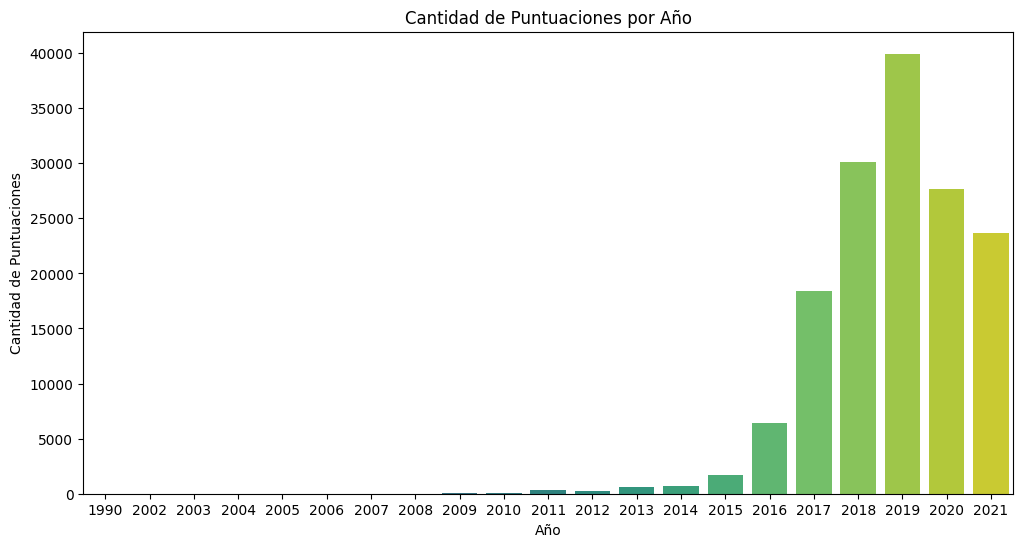

In [37]:
# Extracción del año de la columna 'time' y creación de una nueva columna 'year'
rw_NewYork_1['year'] = rw_NewYork_1['time'].dt.year

# Agrupación de las calificaciones por año y conteo de las mismas
year_ratings = rw_NewYork_1.groupby('year')['rating'].count()

# Reinicio del índice para convertir la serie resultante en un DataFrame
year_ratings_rw_NewYork_1 = year_ratings.reset_index()

# Configuración del tamaño de la figura para la visualización
plt.figure(figsize=(12, 6))

# Creación de un gráfico de barras utilizando seaborn
sns.barplot(x='year', y='rating', data=year_ratings_rw_NewYork_1, palette='viridis')

# Configuración del título y etiquetas de los ejes
plt.title('Cantidad de Puntuaciones por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Puntuaciones')

# Mostrar el gráfico
plt.show()

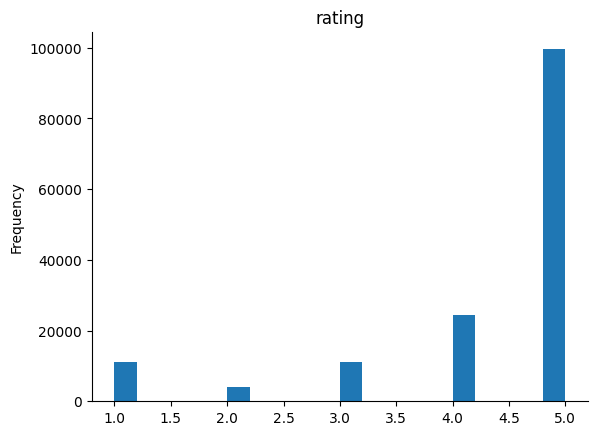

In [38]:
# Creación de un histograma de la columna 'rating'
rw_NewYork_1['rating'].plot(kind='hist', bins=20, title='rating')

# Ocultar las líneas superior y derecha del gráfico
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el histograma
plt.show()


### Dataset: REVIEWS-CALIFORNIA

In [39]:
#Se leen los reviews de California

ruta_reviews_cf = r"C:/Users/Usuario/Desktop/Proyecto Final/reviews-California"
rW_California=[]

i = 1
bandera = True

while bandera:
    try:
        archivo = spark.read.json(f"{ruta_reviews_cf}/{i}.json")
        rW_California.append(archivo)
        i += 1
    except:
        bandera = False

df_final_reviews_cf = rW_California[0]

for dataframe in rW_California[1:]:
    df_final_reviews_cf = df_final_reviews_cf.unionByName(dataframe)
    
rW_California = df_final_reviews_cf

In [40]:
# Conteo de Filas en el DataFrame
rW_California.count()

2700000

In [41]:
#Estructura del esquema del dataframe
rW_California.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [42]:
# Transforma la columna "time" de milisegundos a timestamp.
rW_California = rW_California.withColumn("time", (F.col("time") / 1000).cast('timestamp'))
rW_California.select("time").show()

+--------------------+
|                time|
+--------------------+
|2021-01-06 02:12:...|
|2021-02-09 02:47:...|
|2020-03-08 02:04:...|
|2019-03-07 02:56:...|
|2017-05-16 02:01:...|
|2019-01-18 05:19:...|
|2021-03-29 00:53:...|
|2021-06-20 12:19:...|
|2020-09-29 18:28:...|
|2018-06-10 03:23:...|
|2021-07-28 19:39:...|
|2018-09-04 22:29:...|
|2019-01-06 04:45:...|
|2020-08-20 12:57:...|
|2017-04-18 13:31:...|
|2019-11-07 18:55:...|
|2021-01-19 00:51:...|
|2019-06-21 11:02:...|
|2019-10-24 21:55:...|
|2017-03-08 00:50:...|
+--------------------+
only showing top 20 rows



In [43]:
# Buscamos max y min de time
min_time = rW_California.agg(F.min("time")).collect()[0][0]
max_time = rW_California.agg(F.max("time")).collect()[0][0]

print("Min time: ", min_time)
print("Max time: ", max_time)

Min time:  1990-12-30 21:00:00
Max time:  2021-09-08 22:00:32.337000


In [44]:
# Filtramos por año menores a 2005
rW_California.filter(F.year(rW_California.time) < 2005).show()

+--------------------+--------------------+----+------+----+--------------------+-------------------+--------------------+
|             gmap_id|                name|pics|rating|resp|                text|               time|             user_id|
+--------------------+--------------------+----+------+----+--------------------+-------------------+--------------------+
|0x80c2c7b49b13da5...|       helene landau|NULL|     3|NULL|                NULL|2004-04-06 21:00:00|11055645509278755...|
|0x80c2b4d2ca3e19c...|      Paul Blumstein|NULL|     4|NULL|                NULL|2004-04-03 21:00:00|11812290008149920...|
|0x80c2c4a081e0e7e...|          Jeff Boxer|NULL|     3|NULL|worth a trip to t...|2003-03-30 21:00:00|11616624194309271...|
|0x80c2c556cd7bc59...|          Ron Greene|NULL|     3|NULL|                NULL|2003-05-02 21:00:00|10001700781975095...|
|0x80c2c611c51fbab...|      Pete Kronowitt|NULL|     4|NULL|                NULL|2003-10-30 21:00:00|11281734885859901...|
|0x80c2b94d5ec1c

# __YELP__

__DATASET: BUSINESS__

In [45]:
# Ruta local completa del archivo business.pkl
ruta_local_business = r"C:/Users/Usuario/Desktop/Proyecto Final/Yelp/business.pkl"

In [46]:
# Cargar el archivo pickle usando pd.read_pickle
business_yelp = pd.read_pickle(ruta_local_business)

In [47]:
# Mostramos la info del dataframe
business_yelp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150243 non-null  object
 13  hours         127123 non-null  object
 14  business_id   5 non-null       object
 15  name          5 non-null       object
 16  address       5 non-null       object
 17  city          5 non-null       object
 18  state         5 non-null     

- __Número de Filas y Columnas:__ Hay un total de 150346 filas y 28 columnas en el DataFrame.
- __Columnas y Tipos de Datos:__ El DataFrame consta de 28 columnas, donde cada columna representa una característica o atributo de los negocios de Yelp.
Las columnas contienen principalmente datos de tipo objeto (str).
- __Recuento de Valores no Nulos:__ Se muestra el recuento de valores no nulos para cada columna. Esto indica cuántos valores no nulos hay presentes en cada columna del DataFrame.
- __Uso de Memoria:__ El uso de memoria por el DataFrame se muestra al final, indicando la cantidad de memoria utilizada para almacenar los datos del DataFrame.

In [48]:
# Mostrar las primeras filas del DataFrame de Pandas
business_yelp.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Verificación de columnas duplicadas en el DataFrame business_yelp
columns = business_yelp.columns.duplicated()
columns

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [50]:
# Filtrar el DataFrame business_yelp para eliminar columnas duplicadas
business_yelp = business_yelp.loc[:, ~columns]
business_yelp.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [51]:
# Obtener los valores únicos en la columna 'state' del DataFrame 'business_yelp'
business_yelp.state.unique()


array([nan, 'CA', 'MO', 'AZ', 'PA', 'TN', 'FL', 'IN', 'LA', 'AB', 'NV',
       'ID', 'DE', 'IL', 'NJ', 'NC', 'CO', 'WA', 'HI', 'UT', 'TX', 'MT',
       'MI', 'SD', 'XMS', 'MA', 'VI', 'VT'], dtype=object)

In [52]:
# Reemplazamos los NaN en 'state' por sus valores correspondientes de acuerdo a 'address', 'city' y 'postal_code'
business_yelp.at[0, 'state'] = 'CA'
business_yelp.at[1, 'state'] = 'MO'
business_yelp.at[2, 'state'] = 'AZ'

In [53]:
# Mostrar las primeras filas del DataFrame de Pandas
business_yelp.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [54]:
# Verificar valores nulos en el DataFrame 'business_yelp' y contarlos por columna
business_yelp.isnull().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64

Analisimos loS valores nulos por columnas y arrojo el resultado que _attributes y hours_ son las que mayores cantidades tienen.

In [55]:
# Acceder al valor en la posición cero de la columna 'categories' del DataFrame 'business_yelp'
business_yelp.categories[0]

'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists'

In [56]:
# Dividir las cadenas en la columna 'categories' por comas, expandirlas en filas y eliminar espacios iniciales
business_yelp_categories = business_yelp.categories.str.split(',').explode().str.lstrip()

# Contar el número de valores únicos en la columna 'business_yelp_categories'
business_yelp_categories.nunique()


1311

In [57]:
# Realizar el recuento de valores en la serie 'business_yelp_categories'
business_yelp_categories = business_yelp_categories.value_counts().to_frame(name='count')

# Calcular el porcentaje de cada valor en relación con el total de observaciones en el DataFrame 'business_yelp'
business_yelp_categories['%'] = round(business_yelp_categories['count'] / len(business_yelp) * 100, 2)

# Mostrar los quince valores más comunes junto con su recuento y porcentaje
business_yelp_categories.head(15)


,count,%
categories,,
Restaurants,52268,34.77
Food,27781,18.48
Shopping,24395,16.23
Home Services,14356,9.55
Beauty & Spas,14292,9.51
Nightlife,12281,8.17
Health & Medical,11890,7.91
Local Services,11198,7.45
Bars,11065,7.36


In [58]:
# Filtrar el DataFrame business_yelp_categories para seleccionar las filas cuyos índices contienen la letra 'P'
business_yelp_categories[business_yelp_categories.index.str.contains('P')]

,count,%
categories,,
Event Planning & Services,9895,6.58
Pizza,7093,4.72
Pets,3758,2.50
Professional Services,3270,2.17
Pet Services,2626,1.75
...,...,...
Paragliding,1,0.00
Parklets,1,0.00
Pathologists,1,0.00


In [59]:
# Normaliza 'attributes'
attributes = pd.json_normalize(business_yelp['attributes'])
attributes['business_id'] = business_yelp['business_id']
attributes = attributes.melt(id_vars='business_id', var_name='attribute_key', value_name='attribute_value')
attributes.dropna(inplace=True)
attributes.reset_index(drop=True, inplace=True)

In [60]:
attributes[attributes['attribute_value'] == 'None']

,business_id,attribute_key,attribute_value
774,m0JTpAD6Hf7AO71hmmqxIg,ByAppointmentOnly,None
3702,Xypw6Dn6Mt1gCywme5OoUw,ByAppointmentOnly,None
5941,Bo-AALoRsKeLqfJbcyzm8Q,ByAppointmentOnly,None
6048,gMC-74chzFpSoGbKWWuElg,ByAppointmentOnly,None
7545,fq1gweldy1FqSeazemzReA,ByAppointmentOnly,None
...,...,...,...
1206477,7gEZO8zTIlJdGcWZMBGMsw,HairSpecializesIn,None
1206517,Tqkhl0H83bXDyZJE6S66kQ,HairSpecializesIn,None
1206537,LQMa64U__ryF2J_ArnAsUQ,HairSpecializesIn,None
1206577,eAv4CxnFb19Fpyi9HaiytA,HairSpecializesIn,None


In [61]:
attributes = attributes[attributes['attribute_value'] != 'None']
attributes.reset_index(drop=True, inplace=True)

In [62]:
attributes[attributes['attribute_value'] == 'None']

,business_id,attribute_key,attribute_value


In [63]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193993 entries, 0 to 1193992
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   business_id      1193993 non-null  object
 1   attribute_key    1193993 non-null  object
 2   attribute_value  1193993 non-null  object
dtypes: object(3)
memory usage: 27.3+ MB


In [64]:
# Normaliza 'categories'
categories = business_yelp[['business_id', 'categories']]
categories = categories.explode('categories')
categories = categories.rename(columns={'categories': 'category'})
categories['category'] = categories['category'].str.split(',')
categories = categories.explode('category')

In [65]:
categories[categories.category.isnull()]

,business_id,category
1917,SMYXOLPyM95JvZ-oqnsWUA,None
2243,9ryVeDaaR-le3kiSayTGow,None
3304,xT3J-SP5g49g2FjQfLEQfg,None
3324,_obl2-rphXvtzP3y_ekV1Q,None
4640,mKxCNYEoKt6d_1rXmvRwww,None
...,...,...
144328,szluot9mpdIAnUDGi27__w,None
145039,s54FBcv78I6QNjqznP9oKw,None
146058,KYI2rHE3vTG_z9ddqhp58A,None
148225,DCvA43gLeetay_qttR9ABQ,None


In [66]:
categories.dropna(inplace=True)
categories.reset_index(drop=True, inplace=True)

In [67]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668592 entries, 0 to 668591
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  668592 non-null  object
 1   category     668592 non-null  object
dtypes: object(2)
memory usage: 10.2+ MB


In [68]:
# Normaliza 'hours'
hours = pd.json_normalize(business_yelp['hours'])
hours['business_id'] = business_yelp['business_id']
hours = hours.melt(id_vars='business_id', var_name='day_of_week', value_name='opening_hours')
hours.dropna(inplace=True)
hours.reset_index(drop=True, inplace=True)

In [69]:
hours

,business_id,day_of_week,opening_hours
0,mpf3x-BjTdTEA3yCZrAYPw,Monday,0:0-0:0
1,tUFrWirKiKi_TAnsVWINQQ,Monday,8:0-22:0
2,MTSW4McQd7CbVtyjqoe9mw,Monday,7:0-20:0
3,CF33F8-E6oudUQ46HnavjQ,Monday,0:0-0:0
4,n_0UpQx1hsNbnPUSlodU8w,Monday,0:0-0:0
...,...,...,...
801010,2O2K6SXPWv56amqxCECd4w,Sunday,0:0-0:0
801011,hn9Toz3s-Ei3uZPt7esExA,Sunday,11:0-22:0
801012,IUQopTMmYQG-qRtBk-8QnA,Sunday,11:0-17:0
801013,c8GjPIOTGVmIemT7j5_SyQ,Sunday,0:0-16:0


In [70]:
hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801015 entries, 0 to 801014
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    801015 non-null  object
 1   day_of_week    801015 non-null  object
 2   opening_hours  801015 non-null  object
dtypes: object(3)
memory usage: 18.3+ MB


In [71]:
# Eliminamos'attributes', 'categories' y 'hours' que ya hemos normalizado.
business = business_yelp.drop(columns=['attributes', 'categories', 'hours'])
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open'],
      dtype='object')

In [72]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150346 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
dtypes: object(11)
memory usage: 17.8+ MB


### DOCUMENTACIÓN

Contiene información del comercio, incluyendo localización, atributos y categorías.

- string, 22 caracteres id del negocio, refiere al negocio en business. json
"business_id": "tnhfDv5Il8EaGSXZGiuQGg",

- string, nombre del negocio
"name": "Garaje",

- string, direccion completa del negocio
"address": "475 3rd St",

- string, ciudad
"city": "San Francisco",

- string, codigo de 2 letras del Estado donde se ubica el negocio
"state": "CA",

- string, el codigo postal
"postal code": "94107",

- float, latitud
"latitude": 37.7817529521,

- float, longitud
"longitude": -122.39612197,

- float, rating en estrellas, redondeado a 0 o 0.5
"stars": 4.5,

- entero, numero de reseñas
"review_count": 1198,

- entero, 0 si esta cerrado, 1 si está abierto
"is_open": 1,

- objeto, atributos del negocio como valores. Algunos valores de atributos también pueden ser objetos.
"attributes": {
    "RestaurantsTakeOut": true,
    "BusinessParking": {
        "garage": false,
        "street": true,
        "validated": false,
        "lot": false,
        "valet": false
    },
},
- lista de categorias de los negocios
"categories": [
    "Mexican",
    "Burgers",
    "Gastropubs"
],
- objeto, de dia a hora, las horas son en 24hr
"hours": {
 "Monday": "10:00-21:00",
 "Tuesday": "10:00-21:00",
 "Friday": "10:00-21:00",
 "Wednesday": "10:00-21:00",
 "Thursday": "10:00-21:00",
 "Sunday": "11:00-18:00",
 "Saturday": "10:00-21:00"

### DATASET: checkin.json

In [73]:
# Ruta local completa del archivo checkin.json
ruta_local_checkin = r"C:/Users/Usuario/Desktop/Proyecto Final/Yelp/checkin.json"

In [74]:
yelp_checkin = []

with open(ruta_local_checkin, "r", encoding='utf-8') as filejson:
    # Procesa cada línea del archivo como un objeto JSON
    for linea in filejson:
        # Intenta cargar la línea como un objeto JSON
        objeto = json.loads(linea)
        yelp_checkin.append(objeto)

# Convierte la lista de diccionarios a un DataFrame de Pandas
yelp_checkin = pd.DataFrame(yelp_checkin)

In [75]:
# Muestra la info de nuestro dataframe
yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [76]:
#Muestra las primeras filas
yelp_checkin.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [77]:
# Buscamos duplicados
yelp_checkin.duplicated().sum()

0

In [78]:
# Observamos la estructura de los datos en 'date'
yelp_checkin.date[0]

'2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020-07-24 22:42:27, 2020-10-24 21:36:13, 2020-12-09 21:23:33, 2021-01-20 17:34:57, 2021-04-30 21:02:03, 2021-05-25 21:16:54, 2021-08-06 21:08:08, 2021-10-02 15:15:42, 2021-11-11 16:23:50'

In [79]:
# Divide la columna 'date' en una lista de fechas
yelp_checkin['date'] = yelp_checkin.date.str.split(',')

In [80]:
# Convierte la lista de fechas en filas separadas
yelp_checkin = yelp_checkin.explode('date')

In [81]:
# Limpiar las cadenas de fecha
yelp_checkin['date'] = yelp_checkin['date'].str.strip()

In [82]:
# Convierte la columna 'date' al formato datetime
yelp_checkin['date'] = pd.to_datetime(yelp_checkin['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [83]:
# Ordena el DataFrame por 'date'
yelp_checkin = yelp_checkin.sort_values(['date'])

In [84]:
# Agrega una columna 'id' con un ID único para cada registro
yelp_checkin = yelp_checkin.reset_index(drop=True)
yelp_checkin.insert(0, 'checkin_id', yelp_checkin.index + 1)

In [85]:
# Muestra los primeros datos
yelp_checkin.head()

,checkin_id,business_id,date
0,1,jm_6bIhR_TuciFIk5rhR7g,2009-12-30 02:53:27
1,2,yEKmlxvhA2EWrMLbwWi7Hw,2009-12-31 00:18:24
2,3,TRxR32_T_7Ly_RW4Ke97fw,2010-01-16 00:36:59
3,4,OzoE9NH0xjhfsVMc7ygaaQ,2010-01-16 01:15:27
4,5,7lwe7n-Yc-V9E_HfLAeylg,2010-01-16 02:12:05


In [86]:
#Mustra la info de nuestro data frame
yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356875 entries, 0 to 13356874
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   checkin_id   int64         
 1   business_id  object        
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 305.7+ MB


In [87]:
yelp_checkin.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
checkin_id,13356875.0,NaN,NaN,NaN,6678438.0,1.0,3339219.5,6678438.0,10017656.5,13356875.0,3855797.832729
business_id,13356875,131930,-QI8Qi8XWH3D8y8ethnajA,52144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,13356875,NaN,NaN,NaN,2015-10-19 02:42:58.028557312,2009-12-30 02:53:27,2013-08-07 01:01:35,2015-08-17 17:20:15,2017-11-07 00:49:03.500000,2022-01-19 16:48:37,NaN


### Registros en el negocio.

string, 22 caracteres id del negocio que se refiere al negocio en business.json
"business_id": "tnhfDv5Il8EaGSXZGiuQGg"

string que es una lista de fechas separados por coma, en formato YYYY-MM-DD HH:MM:SS
"date": "2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016-10-15 02:45:18, 2016-11-18 01:54:50, 2017-04-20 18:39:06, 2017-05-03 17:58:02"

### DATASET: review.json

In [88]:
#Se lee el archivo review de yelp

df = spark.read.json("C:/Users/Usuario/Desktop/Proyecto Final/Yelp/review.json")
# Se muestra el esquema del DataFrame
df.printSchema()
yelp_reviews = df.pandas_api()
yelp_reviews.head()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,XQfwVwDr-v0ZS3_CbbE5Xw,0,2018-07-07 22:09:11,0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is...",0,mh_-eMZ6K5RLWhZyISBhwA
1,7ATYjTIgM3jUlt4UM3IypQ,1,2012-01-03 15:28:18,0,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,OyoGAe7OKpv6SyGZT5g77Q
2,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A
3,kxX2SOes4o-D3ZQBkiMRfA,1,2015-01-04 00:01:03,0,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,_7bHUi9Uuf5__HHc_Q8guQ
4,e4Vwtrqf-wpJfwesgvdgxQ,1,2017-01-14 20:54:15,0,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,1,bcjbaE6dDog4jkNY91ncLQ


In [89]:
# Convierte la columna 'date' al formato datetime
yelp_reviews['date'] = yelp_reviews['date'].astype('datetime64[ns]')

In [90]:
# Buscamos duplicados
yelp_reviews.duplicated().sum()
     

0

In [91]:

# Cambia el nombre de la columna 'stars' por 'rating'
yelp_reviews = yelp_reviews.rename(columns={'stars': 'rating'})

In [92]:
# Cambia el nombre de la columna 'text' por 'review'
yelp_reviews = yelp_reviews.rename(columns={'text': 'review'})

In [93]:
# Ordena el DataFrame por 'date'
yelp_reviews = yelp_reviews.sort_values('date')

In [94]:
# Reordena las columnas
yelp_reviews = yelp_reviews[['review_id', 'date', 'user_id', 'business_id', 'review', 'rating', 'cool', 'useful', 'funny']]

In [95]:
# Mostramos las primeras filas de nuestro dataframe
yelp_reviews.head()

,review_id,date,user_id,business_id,review,rating,cool,useful,funny
4179799,IykJMMZgbNcUndwf1q6ieg,2005-02-16 03:23:22,3zBJUlWtPNoZ0uN83ODbyg,2bXm0SynOfxDzfrdrCyXqg,It's not chicago style pizza but it is still a...,4.0,0,0,0
6295220,-O5ng1XLox6uEr4uIZ8u5A,2005-02-16 03:29:39,3zBJUlWtPNoZ0uN83ODbyg,3g6XqkBikTTbZmTukbeGnw,Great service. The people really want to help...,4.0,0,1,0
4887456,g80vzN72iU03Wh0fSpq41g,2005-02-16 04:06:26,3zBJUlWtPNoZ0uN83ODbyg,PP3BBaVxZLcJU54uP_wL6Q,These guys really are the king of cheese steak...,5.0,0,0,0
1423159,7Dcrt0Oz0hikA8obGhadrQ,2005-03-01 16:57:17,XCsZ3hWa_6oP1WkWvK7pmg,U3grYFIeu6RgAAQgdriHww,Words cannot describe how much I miss this pla...,5.0,0,0,0
4884223,WC9q5vhQlQkLK05kEs-vYQ,2005-03-01 16:59:37,XCsZ3hWa_6oP1WkWvK7pmg,Aes-0Q_guDeYewMapFs_vg,Food is decent but is a complete tourist trap....,2.0,0,0,0


Contiene las reseñas completas, incluyendo el user_id que escribió el review y el business_id por el cual se escribe la reseña

string, 22 caracteres id de reseña
"review_id": "zdSx_SD6obEhz9VrW9uAWA",

string, 22 caracteres id único de usuario, refiere al usuario en user.json
"user_id": "Ha3iJu77CxlrFm-vQRs_8g",

string, 22 caracteres id del negocio, refiere al negocio en business.json
"business_id": "tnhfDv5Il8EaGSXZGiuQGg",

entero, puntaje en estrellas de 1 al 5
"stars": 4,

string, fecha formato YYYY-MM-DD
"date": "2016-03-09",

string, la reseña en inglés
"text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

entero, números de votos como reseña útil
"useful": 0,

entero, número de votos como reseña graciosa
"funny": 0,

entero, número de votos como reseña cool.
"cool": 0

### DATASET: tip.json

In [123]:
#Ruta del archivo y declaramos que lo subimos como dataframe de pandas
data_path = 'C:/Users/Usuario/Desktop/Proyecto Final/Yelp/tip.json'
yelp_tips = pd.read_json(data_path, lines=True)
print(yelp_tips.info())
yelp_tips.head()

<class 'pandas.core.frame.DataFrame'>
Index: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 41.6+ MB
None


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [125]:
#Buscamos duplicados
yelp_tips.duplicated().sum()

67

In [126]:
# Elimina duplicados
yelp_tips.drop_duplicates(inplace=True)

In [128]:
# Ordena el DataFrame por 'date'
yelp_tips = yelp_tips.sort_values(['date'])

In [129]:
yelp_tips.rename(columns={'text': 'review'}, inplace=True)

In [130]:
# Agrega una columna 'id' con un ID único para cada registro
yelp_tips = yelp_tips.reset_index(drop=True)
yelp_tips.insert(0, 'tip_id', yelp_tips.index + 1)

In [131]:
yelp_tips.head()

,tip_id,user_id,business_id,review,date,compliment_count
0,1,rCumu_NyXfbyq16cP8vOEw,cXSyVvOr9YRN9diDkaWs0Q,Simply the best breakfast around!! The staff i...,2009-04-16 13:11:49,0
1,2,LT_JU6bY75H918eKnnXeVQ,kLYhipAEvdT1ORfluX5gbw,Crunchy French toast is amazing!,2009-04-16 17:15:29,0
2,3,sxZX1armKzagQxDnbvPnkw,gTC8IQ_i8zXytWSly3Ttvg,"Lunch specials are great, especially their hom...",2009-04-16 19:59:35,0
3,4,KI4UutWtai0UKZ6ZK2pg2Q,P3bw4h4kCaMaYqGGNLt3Jg,"Low selection, quiet",2009-04-16 23:45:46,0
4,5,C14KW1jjKM8QlYfMyzP1sQ,aUjJ_x1KuvWmqIErhdaHzg,"Pretty good pad thai, but when I asked for lim...",2009-04-17 00:34:55,0


### DOCUMENTACIÓN

Tips (consejos) escritos por el usuario. Los tips son más cortas que las reseñas y tienden a dar sugerencias rápidas.

- string, texto del tip
"text": "Secret menu - fried chicken sando is da bombbbbbb Their zapatos are good too.",

- string, fecha cuando se escribio el tip YYYY-MM-DD
"date": "2013-09-20",

- entero, cuantos cumplidos totales tiene
"compliment_count": 172,

- string, 22 caracteres, id del negocio que se refiere al negocio en business.json
"business_id": "tnhfDv5Il8EaGSXZGiuQGg",

- string, 22 caracteres de id de usuario, que se refieren al usuario en user.json
"user_id": "49JhAJh

### DATASET: user.parquet

In [102]:
data_path = 'C:/Users/Usuario/Desktop/Proyecto Final/Yelp/user.parquet'
yelp_users = pd.read_parquet(data_path)
print(yelp_users.info())
yelp_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 353.4+ MB
None


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [103]:
#Buscamos duplicados
yelp_users.duplicated().sum()

117700

In [104]:
# Elimina duplicados
yelp_users.drop_duplicates(inplace=True)

In [105]:
# Convierte 'yelping_since' a datetime
yelp_users['yelping_since'] = pd.to_datetime(yelp_users['yelping_since'])

In [107]:
# Ordena por 'yelping_since'
yelp_users = yelp_users.sort_values('yelping_since')
yelp_users.reset_index(drop=True, inplace=True)

In [108]:
#Muestras las primeras filas del dataframe
yelp_users.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,fFGPBtsutYpn3A155Sf75Q,Brandon,194,2004-10-12 08:46:11,250,103,121,"2006,2007","u-BjshHIamkWw4lBOsyscw, vGtIy5jDIqNS4oT0w-mkfw...",26,...,1,3,11,0,6,11,21,21,1,3
1,nkN_do3fJ9xekchVC-v68A,Jeremy,1366,2004-10-12 08:46:43,18524,10049,15141,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","5HJvYcAM6FLat695V_JF1A, m_y6jQ5AeVpXfTSc9c_LEQ...",2107,...,178,152,249,45,890,1254,2150,2150,473,581
2,wqoXYLWmpkEH0YvTmHBsJQ,Michael,398,2004-10-12 08:51:07,1393,734,662,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2015","g-mL-8J1_9iuDLUhyTzvmg, mjdYqMhqlNi3qz9d2NWgLQ...",156,...,22,13,24,4,90,98,168,168,27,33
3,co_jK_x-CvK2Z3ZrJLz1SQ,j,12,2004-10-12 09:36:53,21,3,4,,"KSoGqlg42blFfukIMfZd_w, OxAPD1OFV9qgS6EmbbHhtw...",0,...,0,0,0,0,1,0,0,0,0,0
4,23J4vG9_xxxdnmi8CBX7Ng,Joan,1674,2004-10-12 12:29:35,21509,15514,19972,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","PNa2-EjHe_ApIgZXD6kxBg, _BHTC7nyCBoZcfiiD5cOXg...",1425,...,292,290,342,98,1480,4961,5126,5126,1904,3291


In [109]:
#muestra las primeras filas de "elite"
yelp_users.elite.head()
     

0                                            2006,2007
1    2006,2007,2008,2009,2010,2011,2012,2013,2014,2...
2    2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
3                                                     
4    2006,2007,2008,2009,2010,2011,2012,2013,2014,2...
Name: elite, dtype: object

In [110]:
# Normaliza 'elite'
elite = yelp_users['elite'].str.split(',', expand=True).stack().reset_index(level=-1, drop=True)
elite = elite.to_frame('elite_year')
elite['user_id'] = yelp_users['user_id']

In [111]:
# Reemplaza los strings en blanco por NaN
elite['elite_year'] = elite['elite_year'].replace('', pd.NA)

In [112]:
# Elimina los NaN
elite = elite.dropna(subset=['elite_year'])

In [113]:
# Ordena el DataFrame por 'elite_year'
elite = elite.sort_values(['elite_year'])

In [114]:
#Muestra los uncios de elite
elite.elite_year.unique()

array(['20', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2021'],
      dtype=object)

In [115]:
#Hace conteos por años en "elite"
elite.elite_year.value_counts()

elite_year
20      79858
2021    44542
2019    44044
2018    41009
2017    36015
2016    29636
2015    24175
2014    18571
2013    16193
2012    15222
2011    10997
2010     8772
2009     5479
2008     3185
2007     2023
2006      775
Name: count, dtype: int64

In [116]:
# Filtrar el DataFrame elite para excluir las filas donde el valor de 'elite_year' es '20'
elite = elite[elite['elite_year'] != '20']

# Restablecer el índice del DataFrame resultante y eliminar el índice anterior
elite.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame elite resultante
elite


,elite_year,user_id
0,2006,fFGPBtsutYpn3A155Sf75Q
1,2006,t9mXmz8cPrCXqTz6tOlveQ
2,2006,S3gNrUh7N9oWoackKlHGMQ
3,2006,H4JNrBAoyCk_ZMZWbAf8OA
4,2006,3XxsH5vS3yJDnYLxSnRu3A
...,...,...
300633,2021,MdGnY6eLxy82nEZhCc6rnQ
300634,2021,grY9VXMDbjzrKiFmKdXPVg
300635,2021,qMhIZuS7OC3v-IN7kU4m2w
300636,2021,6o3CiQzYpLse_kJx2qYfSw


In [117]:
#Muestra la info de "elite"
elite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300638 entries, 0 to 300637
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   elite_year  300638 non-null  object
 1   user_id     300638 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


In [118]:
#elimina la columna elite
yelp_users = yelp_users.drop(columns='elite')

yelp_users.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [119]:
# Dividir la cadena en la posición 1987896 de la columna 'friends' por comas
sample_friends = yelp_users.friends[1987896].split(',')

# Calcular la longitud de la lista resultante
len(sample_friends)

     

1

In [120]:
# Verificar valores nulos en el DataFrame 'business_yelp' y contarlos por columna
yelp_users.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

In [121]:
# Aplicar una función lambda a cada valor en la columna 'friends' del DataFrame 'yelp_users'
# La función divide cada cadena por comas y calcula la longitud de la lista resultante
# Reemplazar los valores originales en la columna 'friends' con las longitudes de las listas resultantes
yelp_users['friends'] = yelp_users['friends'].apply(lambda x: len(x.split(',')))

# Mostrar la columna 'friends' actualizada en el DataFrame 'yelp_users'
yelp_users['friends']


0           245
1          6849
2          2454
3             7
4          3926
           ... 
1987892       1
1987893       1
1987894       1
1987895       1
1987896       1
Name: friends, Length: 1987897, dtype: int64

In [122]:
yelp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             object        
 1   name                object        
 2   review_count        int64         
 3   yelping_since       datetime64[ns]
 4   useful              int64         
 5   funny               int64         
 6   cool                int64         
 7   friends             int64         
 8   fans                int64         
 9   average_stars       float64       
 10  compliment_hot      int64         
 11  compliment_more     int64         
 12  compliment_profile  int64         
 13  compliment_cute     int64         
 14  compliment_list     int64         
 15  compliment_note     int64         
 16  compliment_plain    int64         
 17  compliment_cool     int64         
 18  compliment_funny    int64         
 19  compliment_writer   int64         
 20  co

### DOCUMENTACIÓN

__Data del usuario incluyendo referencias a otros usuarios amigos y a toda la metadata asociada al usuario.__

- string, 22 caracteres, id de usuario que refiere al usuario en user.json
"user_id": "Ha3iJu77CxlrFm-vQRs_8g",

- string, nombre del usuario
"name": "Sebastien",

- entero, numero de reseñas escritas
"review_count": 56,

- string, fecha de creacion del usuario en Yelp en formato YYYY-MM-DD
"yelping_since": "2011-01-01",

- lista con los id de usuarios que son amigos de ese usuario
"friends": [ "wqoXYLWmpkEH0YvTmHBsJQ", "KUXLLiJGrjtSsapmxmpvTA", "6e9rJKQC3n0RSKyHLViL-Q" ],

- entero, número de votos marcados como útiles por el usuario
"useful": 21,

- entero, número de votos marcados como graciosos por el usuario
"funny": 88,

- entero, número de votos marcados como cool por el usuario
"cool": 15,

- entero, número de fans que tiene el usuario
"fans": 1032,

- lista de enteros, años en los que el usuario fue miembro elite
"elite": [ 2012, 2013 ],

- float, promedio del valor de las reseñas
"average_stars": 4.31,

- entero, total de cumplidos 'hot' recibidos por el usuario
"compliment_hot": 339,

- entero, total de cumplidos varios recibidos por el usuario
"compliment_more": 668,

- entero, total de cumplidos por el perfil recibidos por el usuario
"compliment_profile": 42,

- entero, total de cumplidos 'cute' recibidos por el usuario
"compliment_cute": 62,

- entero, total de listas de cumplidos recibidos por el usuario
"compliment_list": 37,

- entero, total de cumplidos como notas recibidos por el usuario
"compliment_note": 356,

- entero, total de cumplidos planos recibidos por el usuario
"compliment_plain": 68,

- entero, total de cumplidos 'cool' recibidos por el usuario
"compliment_cool": 91,

- entero, total de cumplidos graciosos recibidos por el usuario
"compliment_funny": 99,

- entero, número de complidos escritos recibidos por el usuario
"compliment_writer": 95,

- entero, número de cumplidos en foto recibidos por el usuario
"compliment_photos": 50